In [1]:
%cd ..

/cluster/home/aoezkan/rl_proj/recent/distrl_proj


/cluster/home/aoezkan/miniconda3/envs/distrl/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%ls

agents/                     jupyter.out         README.md
config.py                   main.ipynb          requirements.txt
envs/                       monotonicnetworks/  Results/
example_laplace_multgam.py  Networks/           results_plots/
example_laplace.py          notebooks/          start_jupyter.sh
example.py                  __pycache__/        utils/
experiment_utils.py         qrdqn_cartpole.zip  Visualize/
jupyter.err                 quantile_sb3.py


In [3]:
from categorical import *

import gym
import torch

from utils import *
from stable_baselines3.common.monitor import Monitor

from hyperparams.categ_hyper import *



# Select the right environment name
env_name = "CartPole-v1"
# env_name = "LunarLander-v2"
# env_name = "Acrobot-v1"
# env_name = "ALE/Seaquest-v0"

# get the optimal hyperparams for the given env
hyperparams = hyperdict_categ[env_name]

log_dir = os.path.join("logs", "categ", env_name)
# log_dir = os.path.join("logs", "abel", env_name)
# os.makedirs(log_dir, exist_ok=True)

env = gym.make(env_name, render_mode=None)
# env = Monitor(env, log_dir)
# callback = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir)


state_dim = env.observation_space.shape[0]
# required for the categorical to know the action dim
if env_name=='CartPole-v1':
    act_dim = env.action_space.n
elif env_name == 'LunarLander-v2':
    act_dim = env.action_space.n
elif env_name == 'Acrobot-v1':
    act_dim = env.action_space.n
# elif env_name=='Pendulum-v1':
#     act_dim = env.action_space.shape[0]
# elif env_name=='MountainCar-v0':
#     act_dim = env.action_space.n
else:
    raise ValueError('Environment not supported')

n_atoms = hyperparams['n_atoms'] # args.n_atoms
n_units = hyperparams['n-hidden-units'] # args.n_hidden_units
n_layers = hyperparams['n_hidden_layers'] # args.n_hidden_layers
z_net = networks.DistributionalNetwork(inputs=state_dim, n_actions=act_dim, n_atoms=n_atoms,
                                        n_hidden_units=n_units, n_hidden_layers=n_layers)

v_min, v_max = hyperparams['support_range'] # args.support_range
start_train_at = hyperparams['start_train_at'] # args.start_train_at
update_net_every = hyperparams['update_net_every'] # args.update_net_every
epsilon = hyperparams['epsilon'] # args.epsilon
n_steps = hyperparams['n_steps'] # args.n_steps

DDQN = CategoricalDQN(z_net=z_net, n_atoms=n_atoms, v_min=v_min, v_max=v_max,
                        start_train_at=start_train_at,
                        update_every=update_net_every, epsilon=epsilon, log_dir=log_dir, check_freq=100 ,verbose=1)

model_path = os.path.join(log_dir, 'best_model.pkl')
# model_path = 'logs/abel/CartPole-v1/best_model.pkl'
# model_path = 'logs/abel/Acrobot-v1/best_model.pkl'

DDQN_loaded = DDQN.load_model(model_path)

model = DDQN_loaded




ModuleNotFoundError: No module named 'categorical'

In [4]:
model

NameError: name 'model' is not defined

In [7]:
# env_name = "CartPole-v1"
# env_name = "LunarLander-v2"
# env_name = "Acrobot-v1"
# env_name = "ALE/Seaquest-v0"

num_episodes = 50
env = gym.make(env_name, render_mode=None)
env.action_space.seed()

print('Evaluation...:')
obs, _ = env.reset()
reward_list = []


max_T = +np.inf # 200
for i in range(num_episodes):
    rew_ep_list = []
    ep_itr = 0
    while True:
        ep_itr += 1
        with torch.no_grad():
            z = model.z_net(torch.from_numpy(obs).reshape(1,-1))
            action = select_argmax_action(z, model.atoms)
            action = action.numpy().squeeze()
            # action = np.zeros_like(action)
        obs, reward, terminated, truncated, info = env.step(action)
        rew_ep_list.append(reward)
        
        # env.render()
        
        # new time horizon, stop when reached
        if ep_itr>=max_T:
            terminated = True

        if terminated or truncated:
            obs, _ = env.reset()
            break
    reward_list.append(np.array(rew_ep_list).sum())

Evaluation...:


In [8]:
np.array(reward_list)

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500.])

In [9]:
print(np.mean(reward_list))
print(np.std(reward_list))

500.0
0.0


In [10]:
from utils import *


In [11]:
from collections import OrderedDict


import gymnasium as gym

import stable_baselines3
from sb3_contrib import QRDQN
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

from gymnasium.wrappers import FrameStack

# for logging and visuals
from utils import *
from utils.load_model import get_model_env

from stable_baselines3.common.monitor import Monitor

# import hyperparameters
from hyperparams.qrdqn_hyper import *
import os



# Select the right environment name
env_name = "CartPole-v1"
# env_name = "LunarLander-v2"
# env_name = "Acrobot-v1"
# env_name = "ALE/Seaquest-v0"


log_dir = os.path.join("logs", "qdqn", env_name)
# os.makedirs(log_dir, exist_ok=True)


# create the environment
env = gym.make(env_name, render_mode=None)

hyperparams = hyperdict_qrdqn[env_name]
model, env = get_model_env(env_name, env)


model_dir = os.path.join(log_dir, 'best_model.zip')
model = QRDQN.load(model_dir)






Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [12]:
print('Evaluation...:')
obs, _ = env.reset()
# env.action_space.seed(42)
reward_list = []

num_episodes = 50

max_T = +np.inf # 200
for i in range(num_episodes):
    rew_ep_list = []
    ep_itr = 0
    while True:
        ep_itr += 1

        action, _states = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        rew_ep_list.append(reward)
        
        if ep_itr>=max_T:
            terminated = True
        # env.render()
        if terminated or truncated:
            obs, _ = env.reset()
            break
    reward_list.append(np.array(rew_ep_list).sum())

Evaluation...:


In [13]:
np.array(reward_list)

array([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
       500., 500., 500., 500., 500., 500.])

In [14]:
print(np.mean(reward_list))
print(np.std(reward_list))

500.0
0.0


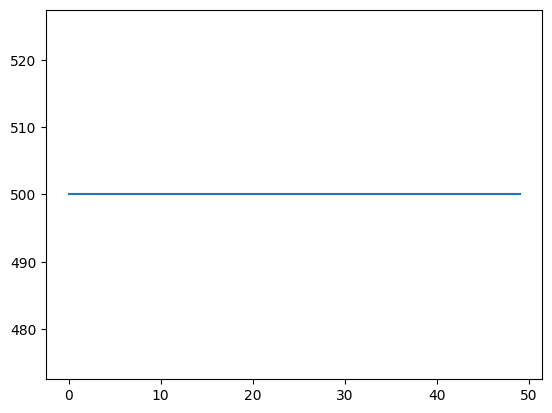

In [15]:
import matplotlib.pyplot as plt

plt.plot(reward_list)

In [1]:
%cd ..

/cluster/home/aoezkan/rl_proj/recent/distrl_proj


/cluster/home/aoezkan/miniconda3/envs/distrl/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
%ls

agents/                     jupyter.out         quantile_sb3.py
config.py                   logs/               README.md
envs/                       main.ipynb          requirements.txt
example_laplace_multgam.py  monotonicnetworks/  Results/
example_laplace.py          Networks/           results_plots/
example.py                  notebooks/          start_jupyter.sh
experiment_utils.py         __pycache__/        utils/
jupyter.err                 qrdqn_cartpole.zip  Visualize/


In [3]:
# LAPLACE TIME HORIZON CHANGE

from config import config_categ

from agents.DQN import DQNAgent
from agents.LaplaceDQN_multgam_4smdp import LaplaceDQNAgentMultgam_4smdp
from agents.LaplaceDQN_multgam import LaplaceDQNAgentMultgam, LaplaceDQNAgentMultgamIntv


import gym
from stable_baselines3.common.monitor import Monitor
import os


In [4]:
import torch
from utils.Inverse_Laplace import SVD_approximation_inverse_Laplace
import numpy as np

In [5]:
# Select the right environment name
env_name = "CartPole-v1"
# env_name = "LunarLander-v2"
# env_name = "Acrobot-v1"
# env_name = "ALE/Seaquest-v0"

# create the environment
env = gym.make(env_name, render_mode=None)

log_dir = os.path.join("logs", "laplace_multgamintv", env_name)
os.makedirs(log_dir, exist_ok=True)

# do monitoring for the largest gamma, and the environment that corresponds to it
# env = Monitor(env, log_dir)

config = config_categ[env_name](env, log_dir)
# with separate gamma networks low, medium, high
laplace_agent = LaplaceDQNAgentMultgamIntv(env_name, config, train=False)

model_path = 'logs/laplace_multgamintv/CartPole-v1/full_gamma'
laplace_agent.load_model(path=model_path)


Playing game:  CartPole-v1
Gammas :  tensor([0.0100, 0.1080, 0.2060, 0.3040, 0.4020, 0.5000, 0.5500, 0.6000, 0.6500,
        0.7000, 0.7500, 0.8100, 0.8700, 0.9300, 0.9900], device='cuda:0')
re-initialized
Gammas :  tensor([0.0100, 0.1080, 0.2060, 0.3040, 0.4020, 0.5000, 0.5500, 0.6000, 0.6500,
        0.7000, 0.7500, 0.8100, 0.8700, 0.9300, 0.9900], device='cuda:0')
policy_net loaded
target_net loaded


In [6]:
laplace_agent.config.device

device(type='cuda')

In [26]:
print('Evaluation...:')
obs, _ = env.reset()
# env.action_space.seed(42)
reward_list = []

num_episodes = 50

max_T = 100 # +np.inf
device = laplace_agent.config.device

for i in range(num_episodes):
    rew_ep_list = []
    ep_itr = 0
    
    while True:
        ep_itr += 1

        # action = laplace_agent.select_action_eval(obs, gamma_idx=-1)
        action = laplace_agent.select_action_after_H_change(obs, time_horizon=max_T, gamma_idx=-1)
        action = action.detach().cpu().squeeze().numpy()
        
        obs, reward, terminated, truncated, info = env.step(action)
        rew_ep_list.append(reward)
        
        if ep_itr>=max_T:
            terminated = True
        # env.render()
        if terminated or truncated:
            obs, _ = env.reset()
            break
        print('i: {}, len: {}'.format(i, ep_itr))
    reward_list.append(np.array(rew_ep_list).sum())

Evaluation...:
i: 0, len: 1
i: 0, len: 2
i: 0, len: 3
i: 0, len: 4
i: 0, len: 5
i: 0, len: 6
i: 0, len: 7
i: 0, len: 8
i: 0, len: 9
i: 1, len: 1
i: 1, len: 2
i: 1, len: 3
i: 1, len: 4
i: 1, len: 5
i: 1, len: 6
i: 1, len: 7
i: 1, len: 8
i: 2, len: 1
i: 2, len: 2
i: 2, len: 3
i: 2, len: 4
i: 2, len: 5
i: 2, len: 6
i: 2, len: 7
i: 2, len: 8
i: 2, len: 9
i: 2, len: 10
i: 3, len: 1
i: 3, len: 2
i: 3, len: 3
i: 3, len: 4
i: 3, len: 5
i: 3, len: 6
i: 3, len: 7
i: 3, len: 8
i: 4, len: 1
i: 4, len: 2
i: 4, len: 3
i: 4, len: 4
i: 4, len: 5
i: 4, len: 6
i: 4, len: 7
i: 5, len: 1
i: 5, len: 2
i: 5, len: 3
i: 5, len: 4
i: 5, len: 5
i: 5, len: 6
i: 5, len: 7
i: 5, len: 8
i: 6, len: 1
i: 6, len: 2
i: 6, len: 3
i: 6, len: 4
i: 6, len: 5
i: 6, len: 6
i: 6, len: 7
i: 6, len: 8
i: 7, len: 1
i: 7, len: 2
i: 7, len: 3
i: 7, len: 4
i: 7, len: 5
i: 7, len: 6
i: 7, len: 7
i: 7, len: 8
i: 7, len: 9
i: 8, len: 1
i: 8, len: 2
i: 8, len: 3
i: 8, len: 4
i: 8, len: 5
i: 8, len: 6
i: 8, len: 7
i: 9, len: 1
i: 9, len

In [27]:
obs

array([ 0.04071951, -0.01468468,  0.03065604, -0.02629088], dtype=float32)

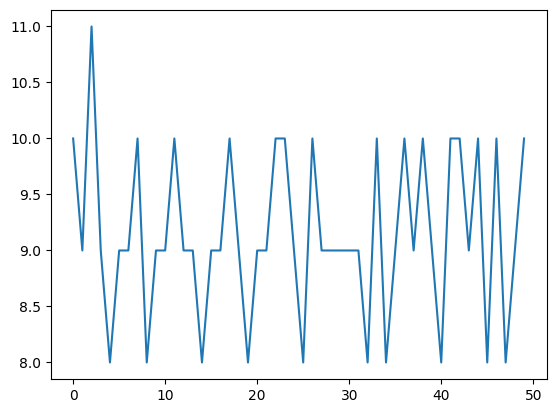

In [28]:
import matplotlib.pyplot as plt

plt.plot(reward_list)

In [29]:
print(np.mean(reward_list))
print(np.std(reward_list))

9.14
0.748598690888516


In [34]:
print(laplace_agent.config.num_sensitivities)
print(laplace_agent.num_gamma_per_module)

100
5


5

In [57]:
import pandas as pd

df_path = os.path.join(log_dir, 'monitor.csv')
df = pd.read_csv(df_path, skiprows=1)

In [58]:
df[-100:].mean()

r     184.630000
l     184.630000
t    4545.200338
dtype: float64

<Axes: >

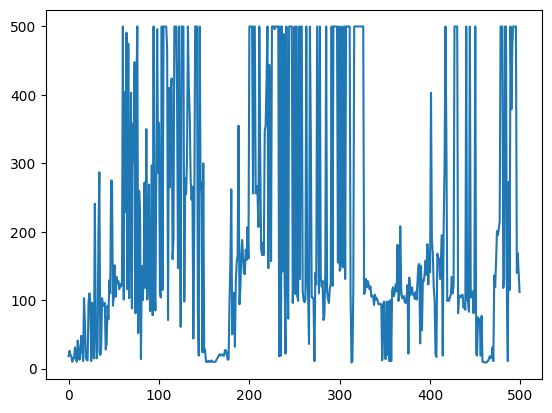

In [59]:
df['r'].plot()

In [22]:
df.mean()

r      53.872185
l     439.592208
t    4821.987236
dtype: float64

In [4]:
print('Evaluation...:')
obs, _ = env.reset()
# env.action_space.seed(42)
reward_list = []

num_episodes = 50

max_T = 200

for i in range(num_episodes):
    rew_ep_list = []
    ep_itr = 0
    while True:
        ep_itr += 1

        action = laplace_agent.select_action_after_H_change(obs, time_horizon=max_T, gamma_idx=-1)
        action = action.squeeze().numpy()
        
        obs, reward, terminated, truncated, info = env.step(action)
        rew_ep_list.append(reward)
        
        if ep_itr>=max_T:
            terminated = True
        # env.render()
        if terminated or truncated:
            obs, _ = env.reset()
            break
    reward_list.append(np.array(rew_ep_list).sum())

Evaluation...:


/Users/alpayozkan/Desktop/projects/RL/distrl_proj/utils/Inverse_Laplace.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gammas_to_tau_tensor = torch.tensor(gammas_to_tau)


Action Values shape after change in time horizon torch.Size([1, 4])


/Users/alpayozkan/opt/anaconda3/envs/distrl_proj/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon torch.Size([1, 4])
Action Values shape after change in time horizon

In [19]:
print(np.mean(reward_list))
print(np.std(reward_list))

9.34
0.7644605941446557


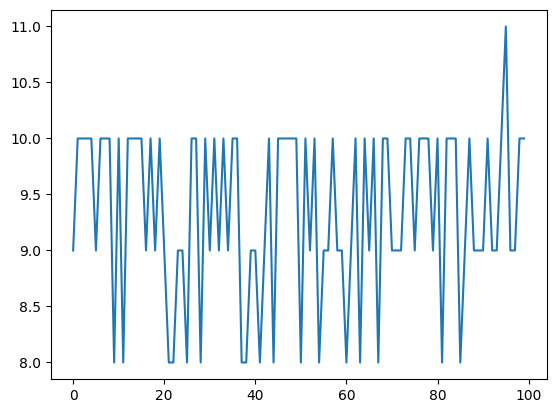

In [20]:
import matplotlib.pyplot as plt

plt.plot(reward_list)

In [85]:
act = action_values.max(1).indices.view(1, 1).squeeze()
act

tensor(3)

In [86]:
env.step(act.numpy())

(array([-0.00564194,  1.4159162 , -0.27874285,  0.09815847,  0.00435545,
         0.0205811 ,  0.        ,  0.        ], dtype=float32),
 1.6471362300564476,
 False,
 False,
 {})

In [28]:
print(laplace_agent.gammas_to_tau.shape)
print(Q_gamma.shape)
print(input.shape)

torch.Size([100])
torch.Size([1, 4, 100, 500])
torch.Size([1, 9])


In [55]:
N = laplace_agent.gammas_to_tau.shape[0]
# states.repeat(N, 1)
states_exp = states.expand(N,-1)

input = torch.cat((states_exp, laplace_agent.gammas_to_tau.unsqueeze(-1)), dim=1)

print(input.shape)
print(states_exp.shape)
print(laplace_agent.gammas_to_tau.shape)

torch.Size([100, 9])
torch.Size([100, 8])
torch.Size([100])


In [65]:
q_out = laplace_agent.policy_net(input)
q_out = q_out.permute(1,0,2).unsqueeze(0)

print(q_out.shape)

torch.Size([1, 4, 100, 500])


torch.Size([1, 4, 100, 500])

In [71]:
torch.allclose(q_out, Q_gamma, atol=1e-7)

True

In [58]:
Q_gamma.shape

torch.Size([1, 4, 100, 500])

In [17]:
if len(states.shape)==1:
    states = states.reshape(1,-1)
input = torch.cat((torch.tensor(states), torch.tensor([laplace_agent.gammas[gamma_idx]]).unsqueeze(0)), dim=1)

In [16]:
len(states.shape)

1

In [13]:
torch.tensor([laplace_agent.gammas[gamma_idx]]).unsqueeze(0).shape

torch.Size([1, 1])

In [14]:
torch.tensor(states).shape

torch.Size([8])

In [ ]:
np.mean(reward_list)

-73.77

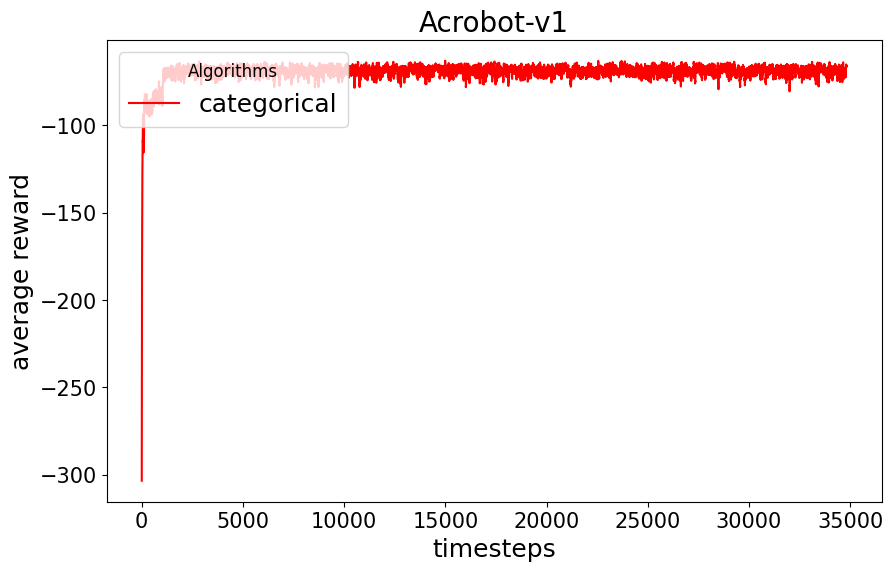

In [ ]:
# env_name = "LunarLander-v2"
# env_name = "CartPole-v1"
env_name = "Acrobot-v1"

df_dir = os.path.join(log_dir, 'monitor.csv')
# os.makedirs(log_dir, exist_ok=True)

df = pd.read_csv(df_dir, skiprows=1)



# from hyperparams.qrdqn_hyper import 
timesteps = hyperdict_categ[env_name]['n_timesteps']

y = df['r'].to_numpy()
x = np.linspace(1, timesteps, len(y))

n = 25
mean_kernel = np.ones(n)/n

y_conv = np.convolve(y, mean_kernel, mode='valid')

plt.figure(figsize=(10, 6))

n_cutoff = y_conv.shape[0]
xx = np.linspace(1, n_cutoff, n_cutoff)

# Plot each curve with a different style, label, and color
plt.plot(xx, y_conv, label='categorical', linestyle='-', color='red')
# plt.plot(x, y_list[2], label=env_list[2], linestyle='-', color='green')

# Add a legend to the plot
# Each entry in the legend automatically matches the color of its corresponding curve
plt.legend(title='Algorithms', loc='upper left')

# Add labels and title
plt.xlabel('timesteps')
plt.ylabel('average reward')
plt.title(env_name)

# Show the plot
plt.show()